## Add AttnPacker to your `PYTHONPATH`

In [1]:
import os
import sys
code_root = os.path.dirname(os.path.dirname(os.getcwd()))
if code_root not in sys.path:
    print(f"Added {code_root} to python path")
    sys.path.append(code_root)
# Faster Inference on CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'


Added /Users/matthewmcpartlon/VSCode/AttnPacker to python path


In [2]:
import torch
from protein_learning.models.inference_utils import (
    Inference,
    make_predicted_protein,
    default
)
import protein_learning.common.protein_constants as pc
import time

# Inference Procedure

### Load the model

The `Inference` class is a wrapper around the AttnPacker Model and is used for performing inference

You should have already downloaded the pretrained model weights and configs ([linked here](https://zenodo.org/record/7559358#.Y83tYuzMI0Q)). To load AttnPacker or AttnPacker+Design, 
specify the directory you downloaded these files to in the parameter `RESOURCE_ROOT`.

In [3]:
RESOURCE_ROOT = "/Users/matthewmcpartlon/Downloads/fbb_design_ft_inference/AttnPackerPTM_V2/"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# Wrapper class for inference
runner = Inference(RESOURCE_ROOT, use_design_variant = False)
runner = runner.to(DEVICE)

[INFO] Initializing AttnPacker Model


### Run Inference

When `format=True` the output of `runner.infer` is a dictionary with keys:

- pred_coords (Tensor[L,37,3])
    - Predicted coordinates (order is given by pc.ALL_ATOM_POSNS)
- pred_seq_logits (Tensor[L,21]) 
    - Residue-Type log likelihoods. Output only when using design variant (Order Given by pc.AA_TO_INDEX)
- pred_plddt (Tensor[L])
    - Predicted per-residue side-chain lDDT scores
- res_output (Tensor[L,L,d_pair])
    - Raw Residue Feature Output 
- pair_output (Tensor[L,d_res])
    - Raw Pair Feature output
- design_mask (Tensor[L]) 
    - Masked residue positions in input sequence (used only with design variant)
- seq (str)
    - String Representaion of Protein Sequence (possibly designed)
- model_out (common.data.data_types.model_output.ModelOutput)
    - Raw output of model.forward()
- model_in (common.data.data_types.model_output.ModelInput)
    - Raw Input to model.forward()
    
Note: The First Forward pass may be slow as the model has not yet been initialized

In [4]:
pdb_path = "./pdbs/T0967.pdb"
start = time.time()
prediction = runner.infer(
    pdb_path=pdb_path, 
    #Boolean Tensor indicating which residues to design
    seq_mask=None, 
    #Whether to format output (process into logits, seq labels, etc. or return raw node and pair output)
    format=True,
    #Chunk inference by successively packing smaller crops of size chunk_size
    #This allows packing of arbitrarily long proteins
    chunk_size = 500,
)
print(f"Ran Inference on {runner.device} in time {round(time.time()-start,2)} seconds")


[INFO] Initializing AttnPacker Model
Ran Inference on cpu in time 1.4 seconds


### Save and Analyze Predictions

Convert prediction into a `Protein` object (`common.data.data_types.protein.Protein`) before saving to PDB 

In [5]:
predicted_protein = make_predicted_protein(model_out = prediction['model_out'], seq = prediction['seq'])
# Save predicted PDB to this location
pdb_out_path = f"./attnpacker_inference/examples/{predicted_protein.name}_packed.pdb"
print(f"saving pdb to {pdb_out_path}")
# write predicted protein with plddt score in b-factor column
predicted_protein.to_pdb(pdb_out_path, beta=prediction["pred_plddt"].squeeze())

saving pdb to ./attnpacker_inference/examples/T0967_packed.pdb


## Run Post-Processing Procedure on Output

As mentioned in the paper, the direct coordinate predictions may not have ideal geometry and
could contain some clashes (though, often the number of clashes is small!)

We can run the post-processing procedure described in the paper to fix this.


In [6]:
def project_coords_to_rotamers(
    protein,
    steric_clash_weight=1.,
    optim_repeats=2,
    max_optim_iters=100,
    steric_loss_kwargs=None,
    device="cpu",
    angle_wt=0
):
    projected_coords, _ = project_onto_rotamers(
        atom_coords = protein.atom_coords.unsqueeze(0),
        sequence = protein.seq_encoding.unsqueeze(0),
        atom_mask = protein.atom_masks.unsqueeze(0),
        steric_clash_weight=steric_clash_weight,
        optim_repeats = optim_repeats,
        steric_loss_kwargs = default(
            steric_loss_kwargs, 
            dict(
                hbond_allowance = 0.6,
                global_allowance = 0.05,
                global_tol_frac = 0.95,
                top_k = 32 # number of neighboring atoms to consider in steric calculations
            )
        ),
        device = DEVICE,
        # set this to smaller value to trade off accuracy and speed.
        # use >= 500 for highest accuracy and ~50 for speed.
        max_optim_iters = max_optim_iters,
        torsion_deviation_loss_wt = angle_wt,
    )
    return projected_coords.squeeze(0)

In [7]:
from protein_learning.protein_utils.sidechains.project_sidechains import project_onto_rotamers
# save optimized packing to the path below
pp_pdb_out_path = f"./attnpacker_inference/examples/{predicted_protein.name}_packed_pp.pdb"
#Please read the doc string for more details
projected_coords = project_coords_to_rotamers(predicted_protein,device=DEVICE)
# write new pdb using optimized coordinates
predicted_protein.to_pdb(pp_pdb_out_path, coords=projected_coords, beta=prediction["pred_plddt"].squeeze())


[fn: project_onto_rotamers] : Using device cpu
[INFO] Beginning rotamer projection
[INFO] Initial loss values
   [RMSD loss] = 0.237
   [Steric loss] = 1.219
   [Angle Dev. loss] = 0.0

beginning iter: 0, steric weight: 1.0
beginning iter: 1, steric weight: 1.0
[INFO] Final Loss Values
   [RMSD loss] = 0.17
   [Steric loss] = 0.0
   [Angle Dev. loss] = 0.015



## Analyze predicted plDDT

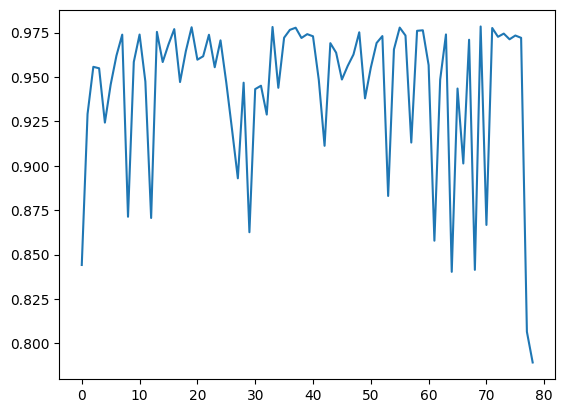

In [8]:
import matplotlib.pyplot as plt
pred_plddt = prediction["pred_plddt"]
plt.plot(torch.arange(pred_plddt.numel()),pred_plddt.squeeze())

## Visualize Optimized Coordinates

In [9]:
view = None
try:
    import nglview as nv
    view = nv.show_file(pp_pdb_out_path)
    view.add_cartoon("protein",color_scheme='residue_index')
    view.add_ball_and_stick("protein")
except:
    pass
view

# Run Inference with Design Variant

To design sequence and side-chains, just initialize the Inference class with `use_design_variant = True`, and use the `design_mask` parameter to indicate which parts of the backbone should be designed.

In [10]:
RESOURCE_ROOT = "/Users/matthewmcpartlon/ProteinLearning/SideChainPacking/AttnPackerPlusRotPTM/"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# Wrapper class for inference
# You can enable rotamer conditioning by setting use_rotamer_conditioning=True
# Note: you will ahve to download the more recent models from zenodo.
runner = Inference(RESOURCE_ROOT, use_design_variant = True, use_rotamer_conditioning=True)
runner = runner.to(DEVICE)

[INFO] Initializing AttnPacker Model


In [11]:
pdb_path = "./pdbs/T0967.pdb"
# this pdb has 79 residues
design_mask = torch.ones(79).bool() # design entire backbone sequence and sidechains
prediction = runner.infer(
    pdb_path=pdb_path, 
    #Boolean Tensor indicating which residues to design
    seq_mask=design_mask, 
    #Boolean Mask indicating which rotamers to condition on
    dihedral_mask=design_mask,
    
)

[INFO] Initializing AttnPacker Model


## Check out sequence Prediction

In [12]:
import math
pred_protein = make_predicted_protein(prediction["model_out"], seq = prediction["seq"])
x,y = prediction["model_out"].decoy_protein.seq, pred_protein.seq

print("Input Sequence :\n",x,"\n")
print("Predicted Sequence :\n",y,"\n")
aln="".join([" " if x[i]!=y[i] else "|" for i in range(len(x))])
nsr = sum([int(a==b) for a,b in zip(x,y)])/len(x)
print(f"Aligned: (NSR={round(nsr*100,1)}%)")
for i in range(math.ceil(len(x)/80)):
    s,e = i*80, (i+1)*80
    print(f" {x[s:e]}\n {aln[s:e]}\n {y[s:e]}\n")


Input Sequence :
 EDYIEAIANVLEKTPSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE 

Predicted Sequence :
 EEDIEELEEKLSKYPAIVAVKSVEAYKDGDTLVFDIELYVPPDISEEEGEEIKAKIDEIVKEIVKEKVEVNVELHDAEV 

Aligned: (NSR=44.3%)
 EDYIEAIANVLEKTPSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE
 |  ||     | | | |  ||   |   |  | | | |||||||    || ||     | ||||  |  | | |  |  
 EEDIEELEEKLSKYPAIVAVKSVEAYKDGDTLVFDIELYVPPDISEEEGEEIKAKIDEIVKEIVKEKVEVNVELHDAEV



Note: you can technically impute the sidechains for *any sequence* using the function below, not just the 
 one predicted by AttnPacker. i.e.

In [13]:
#Set every residue type to Arg.
pred_protein = make_predicted_protein(prediction["model_out"], seq = "".join(["R"]*len(design_mask)))

# fix clashes
all_arg_coords = project_coords_to_rotamers(
    pred_protein,
    steric_loss_kwargs= dict(
        hbond_allowance = 0.5,
        global_allowance = 0.1,
        global_tol_frac = 0.9,
        p=2,
    ),
    steric_clash_weight=1.,
    optim_repeats=3,
    max_optim_iters=200,
)

pp_pdb_out_path = f"./attnpacker_inference/examples/{pred_protein.name}_all_arg_pp.pdb"
pred_protein.to_pdb(pp_pdb_out_path, coords = all_arg_coords)

[fn: project_onto_rotamers] : Using device cpu
[INFO] Beginning rotamer projection
[INFO] Initial loss values
   [RMSD loss] = 1.47
   [Steric loss] = 291.8
   [Angle Dev. loss] = 0.0

beginning iter: 0, steric weight: 1.0
beginning iter: 1, steric weight: 1.0
beginning iter: 2, steric weight: 1.0
[INFO] Final Loss Values
   [RMSD loss] = 1.313
   [Steric loss] = 0.011
   [Angle Dev. loss] = 0.127



## Sample Side-chains and Sequence
(Sort of like Gibbs Sampling)

In [14]:
from protein_learning.models.inference_utils import format_prediction
from protein_learning.common.data.data_types.protein import safe_load_sequence

In [15]:
def sample_seq(logits, temperature=0.1):
    probs = torch.softmax(logits[...,:20]/temperature, dim=-1)
    sampled_seq = torch.utils.data.sampler.WeightedRandomSampler(weights=probs,num_samples=1)
    sampled_seq = [x[0] for x in sampled_seq]
    return "".join([pc.INDEX_TO_AA_ONE[x] for x in sampled_seq]), torch.tensor(sampled_seq)

def score_seq(logits, sample, mask=None):
    if logits is None:
        return -1
    ce = torch.nn.CrossEntropyLoss(ignore_index=-1)
    mask = mask if mask is not None else torch.ones_like(sample,dtype=torch.bool)
    logits,sample,mask = map(lambda x: x.squeeze(),(logits,sample,mask))
    sample[~mask]=-1 #don't score unmasked positions
    return ce(logits,sample).item()

In [17]:
pdb_path = "./pdbs/T0967.pdb"
pdb_name = os.path.split(pdb_path)[-1][:-4]
native_seq = safe_load_sequence(seq_path=None, pdb_path=pdb_path)
model, device = runner.get_model(), runner.device
pred_protein = None
pred_seqs = []
num_samples = 10
resample_frac = lambda step: max(0.2,1/(step+1))
temperature = lambda step: max(0.1,1/(step+2))
unconditional_logits = None
VERBOSE=True

for step in range(num_samples):
    design_mask = torch.rand(len(native_seq))<resample_frac(step)
    model_input = runner.load_example(
        pdb_path, seq_mask = design_mask, dihedral_mask=design_mask, protein=pred_protein
    )
    prediction = model(model_input.to(device))
    prediction = format_prediction(model,model_input,prediction)
    logits = prediction["pred_seq_logits"]
    if torch.all(design_mask):
        unconditional_logits = logits.clone()
    #sample a sequence from logit distribution
    pred_seq, pred_seq_idxs = sample_seq(logits,temperature=temperature(step))
    # compute score (both conditioned on design mask, and unconditional)
    score = score_seq(logits,pred_seq_idxs,design_mask)
    uncond_score = score_seq(unconditional_logits, pred_seq_idxs)
    # runner.load_example expects the protein object on cpu
    pred_protein = make_predicted_protein(prediction["model_out"], seq = pred_seq).to("cpu")
    pred_seqs.append(pred_seq)

    if VERBOSE:
        temp = round(temperature(step),3)
        frac = round(resample_frac(step),3)
        score = round(score,3)
        uncond_score = round(uncond_score,3)
        cmt = f">{pdb_name} step={step} cond_score={score} uncond_score={uncond_score} temp={temp} resample_frac={frac}"
        print(f"{cmt}\n{pred_seq}")

[INFO] Initializing AttnPacker Model
>T0967 step=0 cond_score=1.356 uncond_score=1.356 temp=0.5 resample_frac=1.0
QDVLDELKEELEAYPDIVSVKDLSAYWDGDVLKYDIELYVPPDISEEEGLSIEAKVERIVRHIIDEKTKVDVKLHSAVE
>T0967 step=1 cond_score=0.938 uncond_score=1.158 temp=0.333 resample_frac=0.5
QDVLEELKAELEADPDIVAVKDVSAYQDGDVLKYDIELYVPPDISEEEGLSIEERCEKLVREIIDEKVEVDVKLHSAVE
>T0967 step=2 cond_score=1.18 uncond_score=1.549 temp=0.25 resample_frac=0.333
KDVLEELRKKLEKLPEIVAVKDLRAYQDGDVLIFHIELYVPPDISEEEGLRIKEEVERLVREIIDEKVEVRVRLHDAVE
>T0967 step=3 cond_score=1.012 uncond_score=1.281 temp=0.2 resample_frac=0.25
RDVLEELREKLEKLPEIVAVKDLKAFQDGDVLIFHIELYVPPDITEEEGLRIEEEVEEIVREIIDEKVEVRVRLHDAVE
>T0967 step=4 cond_score=0.803 uncond_score=0.978 temp=0.167 resample_frac=0.2
RDVLEELREKLEKLPEIVAVKDLKAFQDGDVLVFHIELYVPPDITEEEGLRIREEVERIVRELVDEKVEVRVRLHDAEE
>T0967 step=5 cond_score=0.729 uncond_score=0.985 temp=0.143 resample_frac=0.2
EDVLEELREKLEKLPEIVAVKDLKAFQDGDVLVFHIELYVPPDISEEEGLRIRERVEKIVRELVDEKVEVRVRLHDAEE
>T0967 step=

In [18]:
nsr = lambda x,y : sum([int(a==b) for a,b in zip(x,y)])/len(x)
native_seq = safe_load_sequence(seq_path=None, pdb_path=pdb_path)

for x in pred_seqs:
    print(f"Aligned: (NSR={round(nsr(x,native_seq)*100,1)}%)")
    aln="".join([" " if x[i]!=native_seq[i] else "|" for i in range(len(x))])
    for i in range(math.ceil(len(x)/80)):
        s,e = i*80, (i+1)*80
        print(f" {x[s:e]}\n {aln[s:e]}\n {native_seq[s:e]}\n")

Aligned: (NSR=40.5%)
 QDVLDELKEELEAYPDIVSVKDLSAYWDGDVLKYDIELYVPPDISEEEGLSIEAKVERIVRHIIDEKTKVDVKLHSAVE
  |        ||  | |  |||  |   | ||   | |||||||    |  |   |  |   | | |  | | |  | |
 EDYIEAIANVLEKTPSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE

Aligned: (NSR=40.5%)
 QDVLEELKAELEADPDIVAVKDVSAYQDGDVLKYDIELYVPPDISEEEGLSIEERCEKLVREIIDEKVEVDVKLHSAVE
  |  |     ||  | |  |||  |   | ||   | |||||||    |  |         || | |  | | |  | |
 EDYIEAIANVLEKTPSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE

Aligned: (NSR=49.4%)
 KDVLEELRKKLEKLPEIVAVKDLRAYQDGDVLIFHIELYVPPDISEEEGLRIKEEVERLVREIIDEKVEVRVRLHDAVE
  |  |     ||| | |  |||  |   | || | | |||||||    | ||| ||     || | |  | |||  | |
 EDYIEAIANVLEKTPSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE

Aligned: (NSR=50.6%)
 RDVLEELREKLEKLPEIVAVKDLKAFQDGDVLIFHIELYVPPDITEEEGLRIEEEVEEIVREIIDEKVEVRVRLHDAVE
  |  |     ||| | |  |||  |   | || | | ||||||||   | ||  ||  |  || | |  | |||  | |
 EDYIEAIANVLEKTPSISDVK